<a href="https://colab.research.google.com/github/waleedhassan304/Predicting-Taxi-Tip-using-Scikit-Learn-and-Snap-ML/blob/main/taxi_tip_prediction_using_scikit_learn_and_snap_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Taxi Tip Prediction using Scikit-Learn and Snap ML**


Estimated time needed: **30** minutes


**Snap ML** is a high-performance IBM library for ML modeling. It provides highly-efficient CPU/GPU implementations of linear models and tree-based models. Snap ML not only accelerates ML algorithms through system awareness, but also offers novel ML algorithms with best-in-class accuracy. 


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0AXIEN/images/light-traffic-street-night-photography-glass-734324-pxhere.com.jpg" width="65%">


## Objectives

We will perform following tasks in genral:

* Perform basic data preprocessing using Scikit-Learn
* Model a regression task using the Scikit-Learn and Snap ML Python APIs
* Train a Decision Tree Regressor model using Scikit-Learn and Snap ML
* Run inference and assess the quality of the trained models


----


## Setup


### Installing Required Libraries

The following required libraries are pre-installed in the Skills Network Labs environment. However, if you run this notebook commands in a different Jupyter environment (e.g. Watson Studio or Anaconda), you will need to install these libraries by removing the `#` sign before `!mamba` in the code cell below.


In [ ]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# Note: If your environment doesn't support "!mamba install", use "!pip install"

you will need to run the following cell__ to install them:


In [ ]:
!pip install snapml

In [ ]:
from __future__ import print_function
from tqdm import tqdm

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error
import time
import warnings
import gc, sys

sns.set_context('notebook')
sns.set_style('white')

### Defining Helper Functions


In [ ]:
def memory_optimize(df):
    
    """
    optimize data types to reduce memory usage
    
    """
    for col in df.columns:
        if df[col].dtype == 'float':
            col_min = df[col].min()
            col_max = df[col].max()

            if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)

        elif df[col].dtype == 'int':
            col_min = df[col].min()
            col_max = df[col].max()

            if col_max < np.iinfo(np.int8).max and col_min > np.iinfo(np.int8).min:
                df[col] = df[col].astype(np.int8)
            elif col_max < np.iinfo(np.int16).max and col_min > np.iinfo(np.int16).min:
                df[col] = df[col].astype(np.int16)
            elif col_max < np.iinfo(np.int32).max and col_min > np.iinfo(np.int32).min:
                df[col] = df[col].astype(np.int32)
    
    return df

## Introduction

The dataset used in this exercise session is publicly available [here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0AXIEN90-2022-01-01) (all rights reserved by Taxi & Limousine Commission(TLC), City of New York). The TLC Yellow Taxi Trip Records of June, 2019 are used in this notebook. **The prediction of the tip amount can be modeled as a regression problem**. To train the model you can use part of the input dataset and the remaining data can be used to assess the quality of the trained model. First, let's download the dataset.


## Downloading the Dataset


There were originally 7M observations in the dataset. Ideally you will use the full dataset for this exercise. However, to avoid running into out of memory issues due to the data size, we will reduce the size by taking a sample of the first 1M observations. We will only work with the 1M observations for the rest of this project.


I have used  the prepare function from the SKills Network library to download the raw data file from IBM Cloud Storage.


In [ ]:
import skillsnetwork

await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0AXIEN/data/yellow_tripdata_2019-06_1M.tgz", overwrite = True)

  0%|          | 0/2 [00:00<?, ?it/s]

Saved to '.'


## Dataset Analysis


We will look at some summary statistics.





Read the input data:


In [ ]:
raw_data = pd.read_csv('yellow_tripdata_2019-06_1M.csv')
print("There are " + str(len(raw_data)) + " observations in the dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

There are 1000000 observations in the dataset.
There are 19 variables in the dataset.


Display first rows in the dataset:


In [ ]:
raw_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-06-01 0:55,2019-06-01 0:56,1,0.0,1,N,145,145,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,NaN
1,1,2019-06-01 0:06,2019-06-01 0:06,1,0.0,1,N,262,263,2,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5,NaN
2,1,2019-06-01 0:17,2019-06-01 0:36,1,4.4,1,N,74,7,2,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0,NaN
3,1,2019-06-01 0:59,2019-06-01 0:59,0,0.8,1,N,145,145,2,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0,NaN
4,1,2019-06-01 0:03,2019-06-01 0:15,1,1.7,1,N,113,148,1,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5,NaN


Each row in the dataset represents a taxi trip. As shown above, each row has 18 variables. One variable is called `tip_amount` and represents the target variable. Your objective will be to train a model that uses the other variables to predict the value of the `tip_amount` variable. Let's first clean the dataset and retrieve basic statistics about the target variable.


Some trips report 0 tip. It is assumed that these tips were paid in cash. For this study we drop all these rows:


In [ ]:
raw_data = raw_data[raw_data['tip_amount'] > 0]
raw_data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
4,1,2019-06-01 0:03,2019-06-01 0:15,1,1.70,1,N,113,148,1,9.5,3.0,0.5,2.65,0.00,0.3,15.95,2.5,NaN
5,1,2019-06-01 0:28,2019-06-01 0:39,2,1.60,1,N,79,125,1,9.5,3.0,0.5,1.00,0.00,0.3,14.30,2.5,NaN
7,1,2019-06-01 0:54,2019-06-01 1:02,2,1.20,1,N,79,249,1,7.5,3.0,0.5,1.00,0.00,0.3,12.30,2.5,NaN
9,1,2019-06-01 0:29,2019-06-01 1:03,1,8.60,1,N,186,243,1,31.5,3.0,0.5,7.05,0.00,0.3,42.35,2.5,NaN
10,2,2019-06-01 0:01,2019-06-01 0:16,1,1.74,1,N,107,148,1,11.0,0.5,0.5,2.96,0.00,0.3,17.76,2.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999988,1,2019-06-05 12:17,2019-06-05 12:56,1,10.70,1,N,138,163,1,36.0,2.5,0.5,12.00,6.12,0.3,57.42,2.5,NaN
999991,2,2019-06-05 12:58,2019-06-05 13:12,1,1.32,1,N,170,246,1,10.0,0.0,0.5,2.66,0.00,0.3,15.96,2.5,NaN
999993,2,2019-06-05 12:47,2019-06-05 13:24,1,1.86,1,N,161,162,1,21.5,0.0,0.5,4.96,0.00,0.3,29.76,2.5,NaN
999996,2,2019-06-05 12:03,2019-06-05 12:23,1,1.70,1,N,161,236,1,12.5,0.0,0.5,3.16,0.00,0.3,18.96,2.5,NaN


We also remove some outliers, namely those where the tip was larger than the fare cost:


In [ ]:
raw_data = raw_data[(raw_data['tip_amount'] <= raw_data['fare_amount'])]
raw_data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
4,1,2019-06-01 0:03,2019-06-01 0:15,1,1.70,1,N,113,148,1,9.5,3.0,0.5,2.65,0.00,0.3,15.95,2.5,NaN
5,1,2019-06-01 0:28,2019-06-01 0:39,2,1.60,1,N,79,125,1,9.5,3.0,0.5,1.00,0.00,0.3,14.30,2.5,NaN
7,1,2019-06-01 0:54,2019-06-01 1:02,2,1.20,1,N,79,249,1,7.5,3.0,0.5,1.00,0.00,0.3,12.30,2.5,NaN
9,1,2019-06-01 0:29,2019-06-01 1:03,1,8.60,1,N,186,243,1,31.5,3.0,0.5,7.05,0.00,0.3,42.35,2.5,NaN
10,2,2019-06-01 0:01,2019-06-01 0:16,1,1.74,1,N,107,148,1,11.0,0.5,0.5,2.96,0.00,0.3,17.76,2.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999988,1,2019-06-05 12:17,2019-06-05 12:56,1,10.70,1,N,138,163,1,36.0,2.5,0.5,12.00,6.12,0.3,57.42,2.5,NaN
999991,2,2019-06-05 12:58,2019-06-05 13:12,1,1.32,1,N,170,246,1,10.0,0.0,0.5,2.66,0.00,0.3,15.96,2.5,NaN
999993,2,2019-06-05 12:47,2019-06-05 13:24,1,1.86,1,N,161,162,1,21.5,0.0,0.5,4.96,0.00,0.3,29.76,2.5,NaN
999996,2,2019-06-05 12:03,2019-06-05 12:23,1,1.70,1,N,161,236,1,12.5,0.0,0.5,3.16,0.00,0.3,18.96,2.5,NaN


We remove trips with very large fare cost, i.e.: greater than $200.


In [ ]:
raw_data = raw_data[((raw_data['fare_amount'] >=2) & (raw_data['fare_amount'] < 200))]
raw_data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
4,1,2019-06-01 0:03,2019-06-01 0:15,1,1.70,1,N,113,148,1,9.5,3.0,0.5,2.65,0.00,0.3,15.95,2.5,NaN
5,1,2019-06-01 0:28,2019-06-01 0:39,2,1.60,1,N,79,125,1,9.5,3.0,0.5,1.00,0.00,0.3,14.30,2.5,NaN
7,1,2019-06-01 0:54,2019-06-01 1:02,2,1.20,1,N,79,249,1,7.5,3.0,0.5,1.00,0.00,0.3,12.30,2.5,NaN
9,1,2019-06-01 0:29,2019-06-01 1:03,1,8.60,1,N,186,243,1,31.5,3.0,0.5,7.05,0.00,0.3,42.35,2.5,NaN
10,2,2019-06-01 0:01,2019-06-01 0:16,1,1.74,1,N,107,148,1,11.0,0.5,0.5,2.96,0.00,0.3,17.76,2.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999988,1,2019-06-05 12:17,2019-06-05 12:56,1,10.70,1,N,138,163,1,36.0,2.5,0.5,12.00,6.12,0.3,57.42,2.5,NaN
999991,2,2019-06-05 12:58,2019-06-05 13:12,1,1.32,1,N,170,246,1,10.0,0.0,0.5,2.66,0.00,0.3,15.96,2.5,NaN
999993,2,2019-06-05 12:47,2019-06-05 13:24,1,1.86,1,N,161,162,1,21.5,0.0,0.5,4.96,0.00,0.3,29.76,2.5,NaN
999996,2,2019-06-05 12:03,2019-06-05 12:23,1,1.70,1,N,161,236,1,12.5,0.0,0.5,3.16,0.00,0.3,18.96,2.5,NaN


We drop variable that contains the target variable, namely the `total_amount`:


In [ ]:
data = raw_data.drop(['total_amount'], axis=1)
data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee
4,1,2019-06-01 0:03,2019-06-01 0:15,1,1.70,1,N,113,148,1,9.5,3.0,0.5,2.65,0.00,0.3,2.5,NaN
5,1,2019-06-01 0:28,2019-06-01 0:39,2,1.60,1,N,79,125,1,9.5,3.0,0.5,1.00,0.00,0.3,2.5,NaN
7,1,2019-06-01 0:54,2019-06-01 1:02,2,1.20,1,N,79,249,1,7.5,3.0,0.5,1.00,0.00,0.3,2.5,NaN
9,1,2019-06-01 0:29,2019-06-01 1:03,1,8.60,1,N,186,243,1,31.5,3.0,0.5,7.05,0.00,0.3,2.5,NaN
10,2,2019-06-01 0:01,2019-06-01 0:16,1,1.74,1,N,107,148,1,11.0,0.5,0.5,2.96,0.00,0.3,2.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999988,1,2019-06-05 12:17,2019-06-05 12:56,1,10.70,1,N,138,163,1,36.0,2.5,0.5,12.00,6.12,0.3,2.5,NaN
999991,2,2019-06-05 12:58,2019-06-05 13:12,1,1.32,1,N,170,246,1,10.0,0.0,0.5,2.66,0.00,0.3,2.5,NaN
999993,2,2019-06-05 12:47,2019-06-05 13:24,1,1.86,1,N,161,162,1,21.5,0.0,0.5,4.96,0.00,0.3,2.5,NaN
999996,2,2019-06-05 12:03,2019-06-05 12:23,1,1.70,1,N,161,236,1,12.5,0.0,0.5,3.16,0.00,0.3,2.5,NaN


We are dealing with a large dataset, thus we need to make sure we do not run out of memory. We can release the memory occupied by `raw_data` as we do not need it anymore.


In [ ]:
del raw_data
gc.collect()

27

Print the number of trips left in the dataset:


In [ ]:
print("There are " + str(len(data)) + " observations in the dataset.")
print("There are " + str(len(data.columns)) + " variables in the dataset.")

There are 682522 observations in the dataset.
There are 18 variables in the dataset.


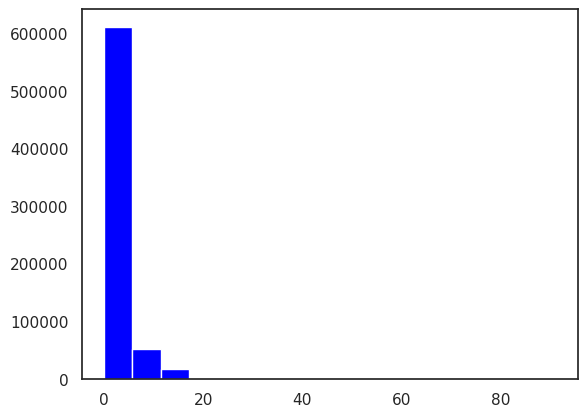

In [ ]:
plt.hist(data.tip_amount.values, 16, histtype='bar', facecolor='b')
plt.show()

In [ ]:
print("Minimum amount value is ", np.min(data.tip_amount.values))
print("Maximum amount value is ", np.max(data.tip_amount.values))
print("90% of the trips have a tip amount less or equal than ", np.percentile(data.tip_amount.values, 90))

Minimum amount value is  0.01
Maximum amount value is  91.0
90% of the trips have a tip amount less or equal than  5.88


In [ ]:
# display first rows in the dataset
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee
4,1,2019-06-01 0:03,2019-06-01 0:15,1,1.70,1,N,113,148,1,9.5,3.0,0.5,2.65,0.0,0.3,2.5,NaN
5,1,2019-06-01 0:28,2019-06-01 0:39,2,1.60,1,N,79,125,1,9.5,3.0,0.5,1.00,0.0,0.3,2.5,NaN
7,1,2019-06-01 0:54,2019-06-01 1:02,2,1.20,1,N,79,249,1,7.5,3.0,0.5,1.00,0.0,0.3,2.5,NaN
9,1,2019-06-01 0:29,2019-06-01 1:03,1,8.60,1,N,186,243,1,31.5,3.0,0.5,7.05,0.0,0.3,2.5,NaN
10,2,2019-06-01 0:01,2019-06-01 0:16,1,1.74,1,N,107,148,1,11.0,0.5,0.5,2.96,0.0,0.3,2.5,NaN


By looking at the dataset in more detail, we see that it contains information such as pick-up and drop-off dates/times, pick-up and drop-off locations, payment types, driver-reported passenger counts etc. 

Before actually training a ML model, we will need to preprocess the data. We need to transform the data in a format that will be correctly handled by the models. For instance, we need to **encode the categorical features**.


## Data Preprocessing

I have prepare the data for training. 


Extract useful features such as pickup and dropoff hour, day of week, and trip duration in minutes.


In [ ]:
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])

# extract pickup and dropoff hour
data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
data['dropoff_hour'] = data['tpep_dropoff_datetime'].dt.hour

# extract pickup and dropoff day of week
data['pickup_day'] = data['tpep_pickup_datetime'].dt.weekday
data['dropoff_day'] = data['tpep_dropoff_datetime'].dt.weekday

# compute trip time in minutes
data['trip_time'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).astype('timedelta64[m]')

Drop the pickup and dropoff datetimes columns as well as the airport_fee column that contains all NaNs :


In [ ]:
data = data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime','airport_fee'], axis=1)

Some features are categorical, we need to encode them. To encode them we use one-hot encoding from the Pandas package.


In [ ]:
get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
proc_data = pd.get_dummies(data, columns = get_dummy_col)

Since we will be working with hundreds of one-hot encoded columns or dummy variables, to make sure we do not run into out of memory issue, we release memory occupied by `data` as we do not need it anymore.


In [ ]:
del data
gc.collect()

3731

Let's examine the data types of `proc_data` using `proc_data.info()`.


In [ ]:
proc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682522 entries, 4 to 999997
Columns: 562 entries, passenger_count to dropoff_day_6
dtypes: float64(9), int64(1), uint8(552)
memory usage: 416.6 MB


In [ ]:
# use helper function "memory_optimize"
proc_data = memory_optimize(proc_data)

# data types are converted and the memory usage reduced
proc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682522 entries, 4 to 999997
Columns: 562 entries, passenger_count to dropoff_day_6
dtypes: float32(9), int8(1), uint8(552)
memory usage: 388.6 MB


Extract the labels from the dataframe:


In [ ]:
y = proc_data[['tip_amount']].values

# drop the target variable from the feature matrix
proc_data = proc_data.drop(['tip_amount'], axis=1)


Now we get the feature matrix used for training in the format of numpy arrays and the normalize the feature matrix. We assign the feature matrix to `X` and release the memory occupied by `proc_data` before proceeding.


In [ ]:
X = proc_data.values

del proc_data
gc.collect()

23

In [ ]:
# normalize the feature matrix
normalizer = Normalizer(norm='l1').fit(X)
X = normalizer.transform(X)

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (682522, 561) y.shape= (682522, 1)


## Dataset Train/Test Split


Now that the dataset is ready for building the classification models, we need to first divide the pre-processed dataset into a subset to be used for training the model (the **train set**) and a subset to be used for evaluating the quality of the model (the **test set**).


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (477765, 561) Y_train.shape= (477765, 1)
X_test.shape= (204757, 561) Y_test.shape= (204757, 1)


In [ ]:
del X, y
gc.collect()

69

## Build a Decision Tree Regressor model with Scikit-Learn


Import the Decision Tree Regression Model from scikit-learn.


In [ ]:
from sklearn.tree import DecisionTreeRegressor

For reproducible output across multiple function calls, set random_state to an integer value.


In [ ]:
sklearn_dt = DecisionTreeRegressor(max_depth=8, random_state=35)

Train a Decision Tree Regressor using scikit-learn and use the `time` function to record the training time.


In [ ]:
t0 = time.time()
sklearn_dt.fit(X_train, y_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  42.42273


## Build a Decision Tree Regressor model with Snap ML


Import the Decision Tree Regressor Model from **Snap ML**.


In [ ]:
from snapml import DecisionTreeRegressor

In contrast to sklearn's Decision Tree, Snap ML offers multi-threaded CPU/GPU training. To use the GPU, one needs to set the parameter `use_gpu = True`:

`snapml_dt = DecisionTreeRegressor(max_depth=4, random_state=45, use_gpu=True)`

To set the number of CPU threads used at training time, one needs to set the `n_jobs` parameter. For reproducible output across multiple function calls, set `random_state` to an integer value.


In [ ]:
snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=45, n_jobs=2)

Train a Decision Tree Regressor model using Snap ML.


In [ ]:
t0 = time.time()
snapml_dt.fit(X_train, y_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  20.03494


## Evaluate the Scikit-Learn and Snap ML Decision Tree Regressor Models


Let's examine the Snap ML vs Scikit-Learn training speedup:


In [ ]:
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : 2.12x 


We can run inference using the sklearn model:


In [ ]:
sklearn_pred = sklearn_dt.predict(X_test)

Evaluate mean squared error on the test dataset:


In [ ]:
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))

[Scikit-Learn] MSE score : 1.741


Run inference using the Snap ML model:


In [ ]:
snapml_pred = snapml_dt.predict(X_test)

Evaluate mean squared error on the test dataset:


In [ ]:
snapml_mse = mean_squared_error(y_test, snapml_pred)
print('[Snap ML] MSE score : {0:.3f}'.format(snapml_mse))

[Snap ML] MSE score : 1.667


As shown above both decision tree models provide the similar score on the test dataset. However Snap ML runs the training routine faster than Scikit-Learn. 

This is one of the advantages of using Snap ML: **acceleration of training of classical machine learning models, such as linear and tree-based models**
